My reinforcement learning dataset will be used to train a GAN. GANs are great, but I don't trust them to simulate game replays. So, I'm going to explore transformations that will ensure my data is normally distributed.

In [1]:
# load blobs 
! wget https://raw.githubusercontent.com/wdurno/rl-hypothesis-1/726ea9451e3d1769d71580dd5f499f84c9a41ff9/docker/app/rl/rl.py

--2020-02-15 16:06:20--  https://raw.githubusercontent.com/wdurno/rl-hypothesis-1/726ea9451e3d1769d71580dd5f499f84c9a41ff9/docker/app/rl/rl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11260 (11K) [text/plain]
Saving to: ‘rl.py.1’

rl.py.1             100%[===================>]  11.00K  --.-KB/s    in 0s      

2020-02-15 16:06:20 (126 MB/s) - ‘rl.py.1’ saved [11260/11260]



In [2]:
! gsutil cp gs://gdax-dnn-tmp-1/rl-full.h5-backup .

Copying gs://gdax-dnn-tmp-1/rl-full.h5-backup...
/ [1 files][  6.5 MiB/  6.5 MiB]                                                
Operation completed over 1 objects/6.5 MiB.                                      


In [3]:
! gsutil cp gs://gdax-dnn-tmp-1/memory.pkl-backup .

Copying gs://gdax-dnn-tmp-1/memory.pkl-backup...
- [1 files][ 10.6 GiB/ 10.6 GiB]   70.8 MiB/s                                   
Operation completed over 1 objects/10.6 GiB.                                     


In [4]:
import pickle
with open('memory.pkl-backup', 'rb') as f:
    mem = pickle.load(f)

In [5]:
print(type(mem))
print(len(mem))
print(type(mem[0]))
print(len(mem[0]))
print(list(map(type, mem[0])))
print((mem[0][0].shape, mem[0][1], mem[0][2], mem[0][3].shape, mem[0][4]))
print(('state', 'action', 'reward', 'next_state', 'dead'))

<class 'collections.deque'>
400000
<class 'tuple'>
5
[<class 'numpy.ndarray'>, <class 'numpy.int64'>, <class 'numpy.float64'>, <class 'numpy.ndarray'>, <class 'bool'>]
((1, 84, 84, 4), 0, 0.0, (1, 84, 84, 4), False)
('state', 'action', 'reward', 'next_state', 'dead')


I won't trust a GAN to simulate game transitions, but I do trust it to simulate normally distributed data. So, I'm going to apply some transition learning.

In [6]:
# missing dependencies 
import sys
! pip install --user tensorflow
! pip install --user keras
sys.path.append('/home/jupyter/.local/lib/python3.5/site-packages')

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.advanced_activations import ReLU
from keras.layers.convolutional import Conv2D

def build_model(state_size, action_size):
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=state_size))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1)))
    model.add(Flatten())
    model.add(ReLU())
    model.add(Dense(512))
    model.add(ReLU())
    model.add(Dense(action_size))
    model.summary()
    return model

full_rl_model = build_model((84, 84, 4), 3)
full_rl_model.load_weights('./rl-full.h5-backup') 

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
re_lu_2 (ReLU)               (None, 512)              

In [8]:
# the model simueltaneously evaluates all actions
full_rl_model.predict(mem[0][0])

array([[79.48269 , 70.353134, 69.84472 ]], dtype=float32)

In [9]:
# make transfer learning models 
from keras.models import Model
rl_1_dense =  Model(inputs=full_rl_model.inputs, outputs=full_rl_model.layers[5].output)
rl_convs =  Model(inputs=full_rl_model.inputs, outputs=full_rl_model.layers[3].output)

In [10]:
# Let's compare these models. 
# I'm concerned about 
# - large tensor sizes eating memory
# - Normally(-ish) distributed data 
# - sufficient abstraction--I want to abstract away visual processing 
print('rl_1_dense shape: ' + str(rl_1_dense.predict(mem[0][0]).shape))
print('rl_convs shape: ' + str(rl_convs.predict(mem[0][0]).shape))

rl_1_dense shape: (1, 512)
rl_convs shape: (1, 3136)


Keeping one dense layer will use about one sixth the memory burden and further abstraction. To evaluate normal distributions, we'll need some plots. Relus have been used, so a transform will be necessary.

In [11]:
# histogram time 
import matplotlib.pyplot as plt
%matplotlib inline
def hist(x, num_bins=50, **kwargs):
    plt.hist(x, num_bins, **kwargs)
    plt.show()
    pass

In [12]:
# sample consecutive states 
import random 
import numpy as np
n = 10000 # sample size 

mem_sub_sample = random.sample(mem, n)
before_sample = np.squeeze(np.array(list(map(lambda x: x[0], mem_sub_sample)))) 
after_sample = np.squeeze(np.array(list(map(lambda x: x[3], mem_sub_sample)))) 
print(after_sample.shape)
print(before_sample.shape)

(10000, 84, 84, 4)
(10000, 84, 84, 4)


In [13]:
# generate paired data 
def predict_and_flatten(model, data=before_sample):
    return model.predict(data)

rl_1_dense_vals_before = predict_and_flatten(rl_1_dense, before_sample)
rl_convs_vals_before = predict_and_flatten(rl_convs, before_sample)
rl_1_dense_vals_after = predict_and_flatten(rl_1_dense, after_sample)
rl_convs_vals_after = predict_and_flatten(rl_convs, after_sample)

In [14]:
print(rl_1_dense_vals_before.shape)
print(rl_convs_vals_before.shape)

(10000, 512)
(10000, 3136)


In [15]:
# consecutive time-steps are likely correlated ... verifying 
def correlations(before, after):
    n_cols = before.shape[1]
    correlations = list(map(lambda idx: np.corrcoef(before[:,idx], after[:,idx])[1][0], range(n_cols)))
    return correlations

rl_1_dense_vals_correlations = correlations(rl_1_dense_vals_before, rl_1_dense_vals_after)
rl_convs_vals_correlations = correlations(rl_convs_vals_before, rl_convs_vals_after) 

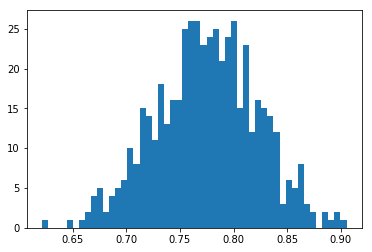

In [16]:
hist(rl_1_dense_vals_correlations)

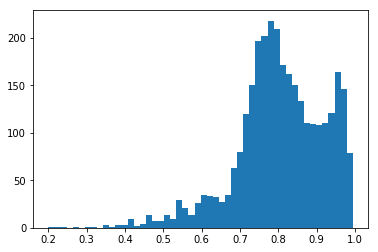

In [17]:
hist(rl_convs_vals_correlations)

Time steps have non-trivial correlations, so I'll attempt to model differences.

In [18]:
rl_1_dense_dels = rl_1_dense_vals_after - rl_1_dense_vals_before
rl_convs_dels = rl_convs_vals_after - rl_convs_vals_before

Platting raw deltas...

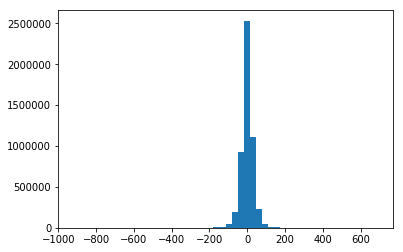

In [19]:
hist(rl_1_dense_dels.flatten())

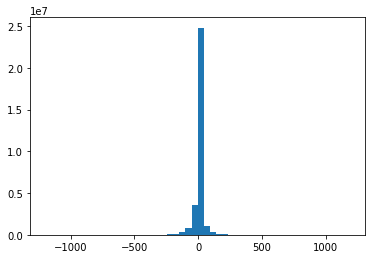

In [20]:
hist(rl_convs_dels.flatten())

Trimming outliers...

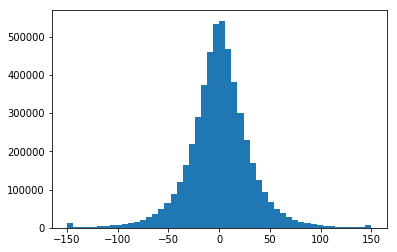

In [21]:
hist(np.clip(rl_1_dense_dels.flatten(), -150, 150))

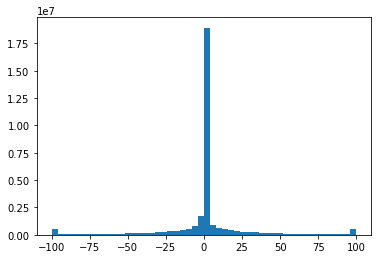

In [22]:
hist(np.clip(rl_convs_dels.flatten(), -100, 100))

Having a near-perfect normal distribution, I'll proceed to attempt simulating `rl_dense_dels`.

Now, we must deal with the fact that `dead` is Boolean. No transform will produce anything nearly normally distributed from this. Worse yet, `reward` suffers similarly...

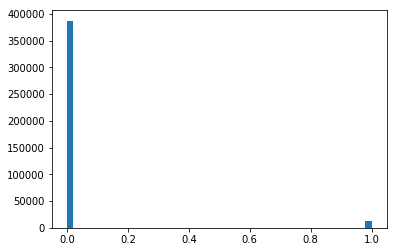

In [23]:
rewards = np.array(list(map(lambda x: x[2], mem))) 
hist(rewards)

In [24]:
print('Number of rewards == 1: ' + str(len(rewards[rewards > .5])))
print('Proportion of rewards == 1: ' + str(len(rewards[rewards > .5])/float(len(rewards))))
print('Distinct reward values: ' + str(np.unique(rewards)))

Number of rewards == 1: 12810
Proportion of rewards == 1: 0.032025
Distinct reward values: [0. 1.]


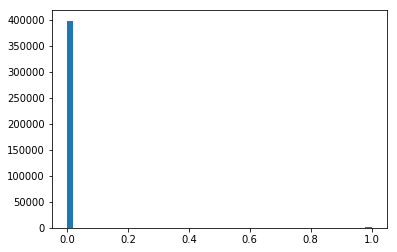

In [25]:
# Let's see how `dead` is distributed 
deads = np.array(list(map(lambda x: int(x[4]), mem))) 
hist(deads)

In [26]:
print('Number of deads == 1: ' + str(len(deads[deads > .5])))
print('Proportion of deads == 1: ' + str(len(deads[deads > .5])/float(len(deads))))
print('Distinct dead values: ' + str(np.unique(deads)))

Number of deads == 1: 1544
Proportion of deads == 1: 0.00386
Distinct dead values: [0 1]


In [27]:
# Is there much overlap between `deads` and `rewards`?
print('dead and rewarded: ' + str(np.sum(deads * rewards)))
print('dead and not rewarded: ' + str(np.sum(deads * (1.-rewards))))
print('not dead and rewarded: ' + str(np.sum((1.-deads) * rewards)))
print('not dead and not rewarded: ' + str(np.sum((1.-deads) * (1.-rewards)))) 

dead and rewarded: 0.0
dead and not rewarded: 1544.0
not dead and rewarded: 12810.0
not dead and not rewarded: 385646.0


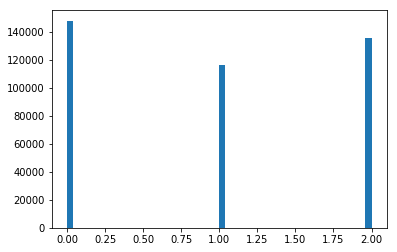

In [28]:
# The same issue is true for `actions`.
actions = np.array(list(map(lambda x: int(x[1]), mem))) 
hist(actions)

In [29]:
# We must avoid attempting to learn cases with no samples, so we'll thoroughly check for mutual exclusitivities.
print('actions == 0 and dead and not rewarded: ' + str(np.sum((actions == 0.) * deads * (1.-rewards))))
print('actions == 1 and dead and not rewarded: ' + str(np.sum((actions == 1.) * deads * (1.-rewards))))
print('actions == 2 and dead and not rewarded: ' + str(np.sum((actions == 2.) * deads * (1.-rewards))))
print('actions == 0 and not dead and rewarded: ' + str(np.sum((actions == 0.) * (1.-deads) * rewards)))
print('actions == 1 and not dead and rewarded: ' + str(np.sum((actions == 1.) * (1.-deads) * rewards)))
print('actions == 2 and not dead and rewarded: ' + str(np.sum((actions == 2.) * (1.-deads) * rewards)))
print('actions == 0 and not dead and not rewarded: ' + str(np.sum((actions == 0.) * (1.-deads) * (1.-rewards))))
print('actions == 1 and not dead and not rewarded: ' + str(np.sum((actions == 1.) * (1.-deads) * (1.-rewards))))
print('actions == 2 and not dead and not rewarded: ' + str(np.sum((actions == 2.) * (1.-deads) * (1.-rewards))))

actions == 0 and dead and not rewarded: 440.0
actions == 1 and dead and not rewarded: 397.0
actions == 2 and dead and not rewarded: 707.0
actions == 0 and not dead and rewarded: 6318.0
actions == 1 and not dead and rewarded: 3073.0
actions == 2 and not dead and rewarded: 3419.0
actions == 0 and not dead and not rewarded: 141214.0
actions == 1 and not dead and not rewarded: 112614.0
actions == 2 and not dead and not rewarded: 131818.0


So, `deads` and `rewards` are mutually exclusive and effectively both Boolean. `actions` has no mutual exclusitivities. Let's calculate our probabilities of occurance.

In [30]:
prob = {}
prob['action_0_dead_1_reward_0'] = np.sum((actions == 0.) * deads * (1.-rewards))/float(len(mem))
prob['action_1_dead_1_reward_0'] = np.sum((actions == 1.) * deads * (1.-rewards))/float(len(mem))
prob['action_2_dead_1_reward_0'] = np.sum((actions == 2.) * deads * (1.-rewards))/float(len(mem))
prob['action_0_dead_0_reward_1'] = np.sum((actions == 0.) * (1.-deads) * rewards)/float(len(mem))
prob['action_1_dead_0_reward_1'] = np.sum((actions == 1.) * (1.-deads) * rewards)/float(len(mem))
prob['action_2_dead_0_reward_1'] = np.sum((actions == 2.) * (1.-deads) * rewards)/float(len(mem))
prob['action_0_dead_0_reward_0'] = np.sum((actions == 0.) * (1.-deads) * (1.-rewards))/float(len(mem))
prob['action_1_dead_0_reward_0'] = np.sum((actions == 1.) * (1.-deads) * (1.-rewards))/float(len(mem))
prob['action_2_dead_0_reward_0'] = np.sum((actions == 2.) * (1.-deads) * (1.-rewards))/float(len(mem))
for k,v in prob.items():
    print('prob['+str(k)+'] = '+str(v))
print('total: '+str(sum(prob.values()))) # verify all cases are covered 

prob[action_0_dead_0_reward_0] = 0.353035
prob[action_1_dead_0_reward_1] = 0.0076825
prob[action_1_dead_1_reward_0] = 0.0009925
prob[action_0_dead_0_reward_1] = 0.015795
prob[action_0_dead_1_reward_0] = 0.0011
prob[action_2_dead_0_reward_1] = 0.0085475
prob[action_1_dead_0_reward_0] = 0.281535
prob[action_2_dead_0_reward_0] = 0.329545
prob[action_2_dead_1_reward_0] = 0.0017675
total: 0.9999999999999999


I must be able to simulate our game transitions, but I don't trust a GAN to simulate Boolean values, so I will use some creative conditioning.

Let `(state, action, reward, next_state, dead)` be represented by the random tuple $(S_t, A_t, R_t, S_{t+1}, D_t)$.

We need to simulate $(S_t, A_t, R_t, S_{t+1}, D_t)$.

GANs can simulate $(S_t, S_{t+1})$ but can't simulate $(A_t, R_t, D_t)$. Fortunately, we're able to calculate exact probabilities of $(A_t, R_t, D_t)$ occurances. So, we'll conditionalize as follows and use cGANs.

$$f_{S_t, A_t, R_t, S_{t+1}, D_t}(s_t, a_t, r_t, s_{t+1}, d_t) = f_{S_t, S_{t+1} | A_t, R_t, D_t}(s_t, s_{t+1} | a_t, r_t, d_t) f_{A_t, R_t, D_t}(a_t, r_t, d_t)$$

Ok, this works. Let's see how transfer learning factors in. Given $q(s_t,a_t)$ is our q-net, let's call our transfered net $q'(s_t, a_t)$. Note that $q' \not \in \mathbb{R}$, it's a matrix.

Our transfered net $q'$ isn't actually a function of $a_t$ (i.e. $q'(s_t,a_t) = q'(s_t)$), so we don't actually need to simulate $A_t$. Instead, we'll actually be simulating $q'(S_t)$. So, our simulation process simplifies as follows.

$$f_{q'(S_t), R_t, q'(S_{t+1}), D_t}(q'(s_t), r_t, q'(s_{t+1}), d_t) = f_{q'(S_t), q'(S_{t+1}) | R_t, D_t}(q'(s_t), q'(s_{t+1}) | r_t, d_t) f_{R_t, D_t}(r_t, d_t)$$

Given this observation, let's recalculate our probabilities for $f_{R_t, D_t}(r_t, d_t)$.

In [31]:
prob = {}
prob['dead_0_reward_0'] = np.sum((1.-deads) * (1.-rewards))/float(len(mem))
prob['dead_1_reward_0'] = np.sum(deads * (1.-rewards))/float(len(mem))
prob['dead_0_reward_1'] = np.sum((1.-deads) * rewards)/float(len(mem))
prob['dead_1_reward_1'] = np.sum(deads * rewards)/float(len(mem))
for k,v in prob.items():
    print('prob['+str(k)+'] = '+str(v))
print('total: '+str(sum(prob.values()))) # verify all cases are covered 

prob[dead_0_reward_1] = 0.032025
prob[dead_0_reward_0] = 0.964115
prob[dead_1_reward_0] = 0.00386
prob[dead_1_reward_1] = 0.0
total: 1.0
